<font color=red>注：此处是文档第145页</font>

# 空间变换器网络
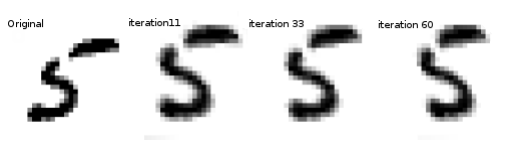

在本教程中，您将学习如何使用称为空间变换器网络的视觉注意机制来扩充您的网络。你可以在 [DeepMind paper](https://arxiv.org/abs/1506.02025) 阅读更多有关空间变换器网络的内容。

空间变换器网络是对任何空间变换的差异化关注的概括。空间变换器网络（简称STN）允许神经网络学习如何在输入图像上执行空间变换， 以增强模型的几何不变性。例如，它可以裁剪感兴趣的区域，缩放并校正图像的方向。而这可能是一种有用的机制，因为CNN对于旋转和缩放以及更一般的仿射变换并不是不变的。

关于`STN`的最棒的事情之一是能够简单地将其插入任何现有的CNN，而且只需很少的修改。

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
plt.ion() # 交互模式

## 1.加载数据
在这篇文章中，我们尝试了经典的 `MNIST` 数据集。使用标准卷积网络增强空间变换器网络。

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "../../data/"
# 训练数据集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=root_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])), batch_size=64, shuffle=True, num_workers=4)

# 测试数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=root_dir, train=False, 
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])), batch_size=64, shuffle=True, num_workers=4)

## 2.什么是空间变换器网络？
[论文笔记：空间变换网络（Spatial Transformer Networks）](https://www.cnblogs.com/liaohuiqiang/p/9226335.html)
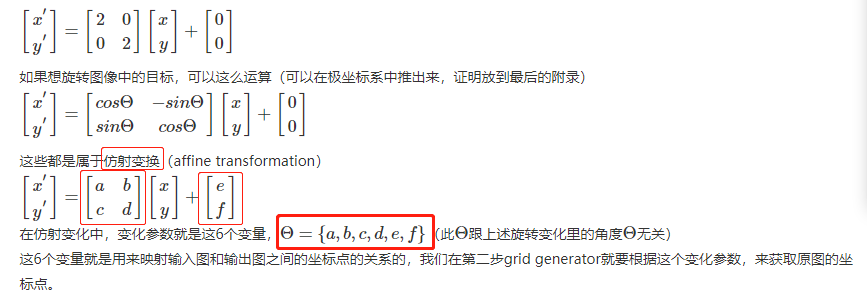

空间变换器网络归结为三个主要组成部分：
- 本地网络（Localisation Network）是常规CNN，其对变换参数进行回归。不会从该数据集中明确地学习转换，而是网络自动学习增强全局准确性的空间变换。
- 网格生成器(Grid Genator)在输入图像中生成与输出图像中的每个像素相对应的坐标网格。
- 采样器（Sampler）使用变换的参数并将其应用于输入图像。
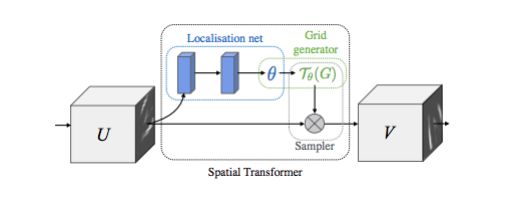

<font color='red'>注意：</font>我们使用最新版本的Pytorch，它应该包含`affine_grid`和`grid_sample`模块。

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # 空间变换器定位 - 网络
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )
        
        # 3 * 2 affine矩阵的回归量
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        # 使用身份转换初始化权重/偏差
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # 空间变换器网络转发功能
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        return x
        
    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # 执行一般的前进传递
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        

model = Net().to(device)

## 3.训练模型
训练模型：现在我们使用 SGD（随机梯度下降）算法来训练模型。网络正在以有监督的方式学习分类任务。同时，该模型以端到端的方式自动学习STN。

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
#
# 一种简单的测试程序，用于测量STN在MNIST上的性能。.
#
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # 累计批量损失
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # 获取最大对数概率的索引
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

## 4.可视化STN结果
现在，我们将检查我们学习的视觉注意机制的结果。我们定义了一个小辅助函数，以便在训练时可视化变换。

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.406913
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.262569

Test set: Average loss: 0.1235, Accuracy: 9623/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.279535
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.339041

Test set: Average loss: 0.0831, Accuracy: 9746/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.173617
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.320348

Test set: Average loss: 0.0760, Accuracy: 9759/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.319375
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.191238

Test set: Average loss: 0.0894, Accuracy: 9726/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.307485
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.130466

Test set: Average loss: 0.0655, Accuracy: 9796/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.174828
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.112260

Test set: Average loss: 0.0591, Accuracy: 9819/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.098582
Train Epoch: 7 [320

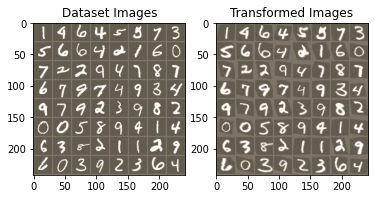

In [15]:
def convert_image_np(inp: torch.Tensor):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# 我们想要在训练之后可视化空间变换器层的输出
# 我们使用STN可视化一批输入图像和相应的变换批次。
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data 
        data = next(iter(test_loader))[0].to(device)
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        
        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')


for epoch in range(1, 20, + 1):
    train(epoch)
    test()

# 在某些输入批处理上可视化STN转换
visualize_stn()
plt.ioff()
plt.show()